## Assignment - 2: MLP - Apple Stock Price Time Series Forecasting
### ID: eo9232
### Name: Md Reza
### IE7860 - Winter 2022

In [1]:
import numpy as np
import pandas as pd 
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa import stattools
import matplotlib.pyplot as plt

from pykalman import KalmanFilter
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [2]:
# Reading the dataset
aapl_df = pd.read_csv(r'AAPL.csv')
aapl_df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,1/4/2010,7.622500,7.660714,7.585000,7.643214,493729600,6.544687
1,1/5/2010,7.664286,7.699643,7.616071,7.656429,601904800,6.556001
2,1/6/2010,7.656429,7.686786,7.526786,7.534643,552160000,6.451719
3,1/7/2010,7.562500,7.571429,7.466071,7.520714,477131200,6.439792
4,1/8/2010,7.510714,7.571429,7.466429,7.570714,447610800,6.482607


## Data Preprocessing

In [3]:
# Create subset with Date & Closing value
aapl_close = pd.DataFrame(aapl_df['Close'])
aapl_close.index = pd.to_datetime(aapl_df['Date'])
aapl_close.head()

,Close
Date,
2010-01-04,7.643214
2010-01-05,7.656429
2010-01-06,7.534643
2010-01-07,7.520714
2010-01-08,7.570714


## Handling missing values

In [4]:
aapl_close.isnull().any()

Close    False
dtype: bool

## Data Exploration 

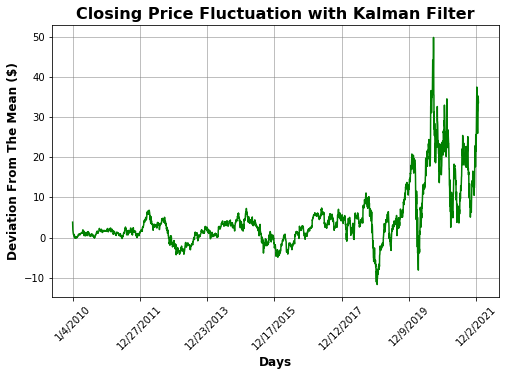

In [5]:
kf = KalmanFilter(transition_matrices = [1], observation_matrices = [1], initial_state_mean = 0, 
                         initial_state_covariance = 1, observation_covariance = 1,transition_covariance = 0.0001)
mean, cov = kf.filter(aapl_df['Close'].values)
mean, std = mean.squeeze(), np.std(cov.squeeze())
plt.figure(figsize=(8,5))
plt.plot(aapl_df['Close'].values - mean, 'g', lw=1.5)
plt.xticks(range(0,aapl_df.shape[0],500),aapl_df['Date'].loc[::500],rotation=45)
plt.title("Closing Price Fluctuation with Kalman Filter", weight='bold', fontsize=16)
plt.ylabel("Deviation From The Mean ($)", weight='bold', fontsize=12)
plt.xlabel("Days", weight='bold', fontsize=12)
plt.grid(color = 'gray', linewidth = 0.5)
plt.show()

##### LJung Box Test for White Noise Detection

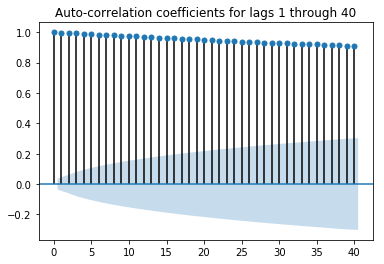

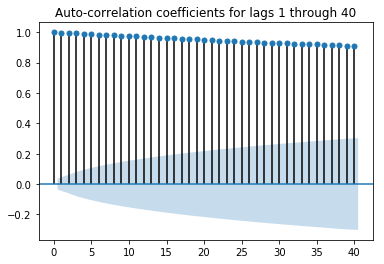

In [6]:
# Auto-correlation plot
import statsmodels.graphics.tsaplots as tsa
tsa.plot_acf(aapl_close['Close'], lags=40, alpha=0.05, title='Auto-correlation coefficients for lags 1 through 40')

## Find The Best Regressor Input 

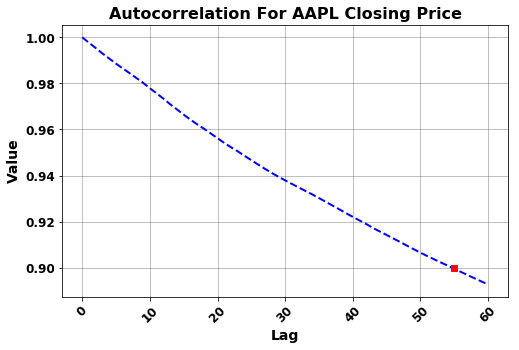

In [7]:
acf_djia, confint_djia, qstat_djia, pvalues_djia = stattools.acf(aapl_close, unbiased=True, nlags=60, qstat=True, fft=True, alpha = 0.05)
plt.figure(figsize=(8, 5))
plt.plot(pd.Series(acf_djia), color='b', linewidth=2, linestyle='dashed')
plt.plot(55, .9, "s", color ='r')
plt.title('Autocorrelation For AAPL Closing Price', weight='bold', fontsize=16)
plt.xlabel('Lag', weight='bold', fontsize=14)
plt.ylabel('Value', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'gray', linewidth = 0.5)
plt.show()

##### From the correlation plot above, at the scale of 90% correlation, the best regressor input appeared to be 55.
##### Therefore, this model will use the past 55 days' stock's closing price to predict the closing price of any given day.

## Data Preperation

In [8]:
# Function to create regressor attributes

def regressor_attribs(aapl_df, attribute, list_of_prev_t_instants) :
    list_of_prev_t_instants.sort()
    start = list_of_prev_t_instants[-1] 
    end = len(aapl_df)
    aapl_df['datetime'] = aapl_df.index
    aapl_df.reset_index(drop=True)

    aapl_df_copy = aapl_df[start:end]
    aapl_df_copy.reset_index(inplace=True, drop=True)

    for attribute in attribute :
            foobar = pd.DataFrame()

            for prev_t in list_of_prev_t_instants :
                new_col = pd.DataFrame(aapl_df[attribute].iloc[(start - prev_t) : (end - prev_t)])
                new_col.reset_index(drop=True, inplace=True)
                new_col.rename(columns={attribute : '{}_(t-{})'.format(attribute, prev_t)}, inplace=True)
                foobar = pd.concat([foobar, new_col], sort=False, axis=1)

            aapl_df_copy = pd.concat([aapl_df_copy, foobar], sort=False, axis=1)
            
    aapl_df_copy.set_index(['datetime'], drop=True, inplace=True)
    return aapl_df_copy

# Create regressor attributes list
list_of_attributes = ['Close']
list_of_prev_t_instants = []
for i in range(1,56): #The best regressor input appeared to be 55.
    list_of_prev_t_instants.append(i)

In [9]:
# Create a new dataset with regressor attributes to include corresponding prices of the past 55 days to predict the closing price for any given day.
aapl_df_new = regressor_attribs(aapl_close, list_of_attributes, list_of_prev_t_instants)
aapl_df_new.shape

(2964, 56)

## Training, Validation, & Test Split

In [10]:
# Training: 90% , Validation: 5%, & Testing: 5%

aapl_df_copy = aapl_df_new.reset_index(drop=True)
df_test = aapl_df_copy.iloc[ int(np.floor(len(aapl_df_copy)*(1 - 0.05))) : ]
df_train_plus_valid = aapl_df_copy.iloc[ : int(np.floor(len(aapl_df_copy)*(1 - 0.05))) ]

df_train = df_train_plus_valid.iloc[ : int(np.floor(len(df_train_plus_valid)*(1 - 0.05))) ]
df_valid = df_train_plus_valid.iloc[ int(np.floor(len(df_train_plus_valid)*(1 - 0.05))) : ]

X_train, y_train = df_train.iloc[:, 1:], df_train.iloc[:, 0]
X_valid, y_valid = df_valid.iloc[:, 1:], df_valid.iloc[:, 0]
X_test, y_test = df_test.iloc[:, 1:], df_test.iloc[:, 0]

print('Shape of training inputs:', X_train.shape)
print('Shape of training target:', y_train.shape)
print('Shape of validation inputs,:', X_valid.shape)
print('Shape of validation target:', y_valid.shape)
print('Shape of test inputs:', X_test.shape)
print('Shape of test target:', y_test.shape)

Shape of training inputs: (2674, 55)
Shape of training target: (2674,)
Shape of validation inputs,: (141, 55)
Shape of validation target: (141,)
Shape of test inputs: (149, 55)
Shape of test target: (149,)


## Normalizing/Scaling the data

In [11]:
Target = MinMaxScaler(feature_range=(0.01, 0.99))
Feature = MinMaxScaler(feature_range=(0.01, 0.99))

X_train_s = Feature.fit_transform(np.array(X_train))
X_valid_s = Feature.fit_transform(np.array(X_valid))
X_test_s = Feature.fit_transform(np.array(X_test))

y_train_s = Target.fit_transform(np.array(y_train).reshape(-1,1))
y_valid_s = Target.fit_transform(np.array(y_valid).reshape(-1,1))
y_test_s = Target.fit_transform(np.array(y_test).reshape(-1,1))

## Building the MLP Model

In [12]:
input_layer = Input(shape=(55), dtype='float32')
hidden_layer1 = Dense(60, kernel_regularizer=l2(1e-5), activation='linear')(input_layer)
hidden_layer2 = Dense(60, kernel_regularizer=l2(1e-5), activation='linear')(hidden_layer1)
dropout = Dropout(0.2)(hidden_layer2)
output_layer = Dense(1, activation='linear')(dropout)

## Model Compilation

In [13]:
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 55)]              0         
_________________________________________________________________
dense (Dense)                (None, 60)                3360      
_________________________________________________________________
dense_1 (Dense)              (None, 60)                3660      
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 61        
Total params: 7,081
Trainable params: 7,081
Non-trainable params: 0
_________________________________________________________________


## Training and Validation

In [14]:
es = EarlyStopping(monitor='val_loss', mode='auto',verbose=1, patience=15)
model.fit(x=X_train_s, 
          y=y_train_s, 
          batch_size=5, 
          epochs=50, 
          verbose=1, 
          validation_data=(X_valid_s, y_valid_s), 
          shuffle=True, 
          callbacks=[es])

Train on 2674 samples, validate on 141 samples
Epoch 1/50
2674/2674 [==============================] - 2s 642us/sample - loss: 0.0077 - val_loss: 0.0417
Epoch 2/50
2674/2674 [==============================] - 1s 362us/sample - loss: 0.0027 - val_loss: 0.0207
Epoch 3/50
2674/2674 [==============================] - 1s 380us/sample - loss: 0.0024 - val_loss: 0.0204
Epoch 4/50
2674/2674 [==============================] - 1s 373us/sample - loss: 0.0021 - val_loss: 0.0202
Epoch 5/50
2674/2674 [==============================] - 1s 388us/sample - loss: 0.0023 - val_loss: 0.0198
Epoch 6/50
2674/2674 [==============================] - 1s 418us/sample - loss: 0.0020 - val_loss: 0.0246
Epoch 7/50
2674/2674 [==============================] - 1s 458us/sample - loss: 0.0019 - val_loss: 0.0143
Epoch 8/50
2674/2674 [==============================] - 1s 417us/sample - loss: 0.0020 - val_loss: 0.0178
Epoch 9/50
2674/2674 [==============================] - 1s 418us/sample - loss: 0.0016 - val_loss: 0.0231

## Evaluate The MLP Model

In [15]:
# Scaling the original predicted values
from sklearn import metrics
y_pred = model.predict(X_test_s)
rescaled_y_pred = Target.inverse_transform(y_pred)
rescaled_y_test = Target.inverse_transform(y_test_s)

In [16]:
y_actual = pd.DataFrame(rescaled_y_test, columns=['Actual Closing Price'])
y_predicted = pd.DataFrame(rescaled_y_pred, columns=['Predicted Closing Price'])
result = pd.concat([y_actual, y_predicted], axis =1)
result.tail(10)

,Actual Closing Price,Predicted Closing Price
139,179.300003,175.653961
140,172.259995,177.448227
141,171.139999,177.340836
142,169.750000,176.060425
143,172.990005,174.654816
144,175.639999,174.857803
145,176.279999,173.477463
146,180.330002,175.522324
147,179.289993,178.125626
148,179.380005,177.310471


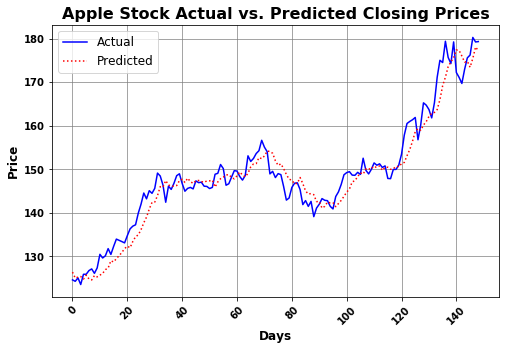

In [17]:
plt.figure(figsize=(8, 5))
plt.plot(y_actual, linestyle='solid', color='b')
plt.plot(y_predicted, linestyle='dotted', color='r')

plt.legend(['Actual','Predicted'], loc='best', prop={'size': 12})
plt.title('Apple Stock Actual vs. Predicted Closing Prices', weight='bold', fontsize=16)
plt.ylabel('Price', weight='bold', fontsize=12)
plt.xlabel('Days', weight='bold', fontsize=12)
plt.xticks(weight='bold', fontsize=10, rotation=45)
plt.yticks(weight='bold', fontsize=10)
plt.grid(color = 'gray', linewidth='0.7')
plt.show()

## Calculate:

<ul>
<li>R-Squared Score</li>
<li>Mean Squared Log Error (MSLE)</li>
<li>Mean Absolute Percentage Error (MAPE)</li>
</ul>

In [18]:
score = r2_score(rescaled_y_test, rescaled_y_pred)
print('\x1b[1;03;30;46m'+'R-Squared Score:', round(score,4), '\x1b[0m')
MSLE = metrics.mean_squared_log_error(rescaled_y_test, rescaled_y_pred)
print('\x1b[1;03;30;46m'+'\nMean Squared Log Error:', round(MSLE,4), '\x1b[0m')

R-Squared Score: 0.937 

Mean Squared Log Error: 0.0004 


In [19]:
def mape(predictions, actuals):
    """Mean absolute percentage error"""
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    return (np.absolute(predictions - actuals) / actuals).mean()

print('\x1b[1;03;30;46m'+'Mean Absolute Percentage Error (MAPE): '
      , round(mape(y_predicted, y_actual)*100,2), '%''\x1b[0m')

Mean Absolute Percentage Error (MAPE):  1.69 %
